# **Avance 4. Modelos Alternativos**

## **Equipo #5**

**Integrantes y matriculas**

* Isaac Manriquez Calderon - A01206674
* Marcos Eduardo Garcia Ortiz - A01276213
* Jesus David Talamantes Morales - A01706335

In [48]:
# Importar Librerias.

import warnings
warnings.filterwarnings('ignore')

# Comando para recargar cambios en librerias automaticamente.
%load_ext autoreload 
%autoreload 2

# Librerias para el manejo del ambiente y documentos
import sys, os
from pathlib import Path
sys.path.append(os.path.abspath(os.path.join('..')))

# Librerias generales de matematicas
import numpy as np
import matplotlib.pyplot as plt 

# Librerias Locales del Repositorio.
# Librerias Locales del Repositorio.
from watermark.features import Utilities, Encription_images
from watermark.dataset import DataHandler
from watermark.plots import PlotHandler

# Librerias de Python
import json
import random
import numpy as np  # Operaciones con arrays y matemáticas
import matplotlib.pyplot as plt  # Visualización de gráficos


# Librerias de Procesamiento de Imagenes
import pywt  # Wavelet transform
from scipy.fftpack import dct
from imagehash import phash  # Librería para hash perceptual

# Librerias de Machine Learning
from PIL import Image
import torch
from torchvision import models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fase 0. Generar DataSet de Imagenes.

### 1. Transformar los Datos a Imagenes

- Vamos a generar una base de datos de imagenes utilizando los datos de X, Y y Presion que estan dentro de la base de datos PKL.

In [57]:
# Vamos a sacar los datos del Dataset.
# Cargamos los datos del Dataset.
dh = DataHandler() #Objeto que maneja datos.
data_dict = dh.load_data(Path("../data/raw"), "emothaw_data.pkl")

2025-02-16 22:27:16.403 | INFO     | watermark.dataset:load_data:54 - Loading data from ..\data\raw\emothaw_data.pkl
2025-02-16 22:27:16.537 | SUCCESS  | watermark.dataset:load_data:59 - Data loaded successfully from ..\data\raw\emothaw_data.pkl


In [58]:
# Sacamos los 
x_data_in = {} # Diccionario de Puntos en X por tarea.
y_data_in = {} # Diccionario de Puntos en Y por Tarea.
p_data_in = {} # Diccionario de Presion en cada momento por tarea.
for key in data_dict.keys():
    x_data_in[key] = [serie.X for serie in data_dict[key]] 
    y_data_in[key] = [serie.Y for serie in data_dict[key]] 
    p_data_in[key] = [serie.Pressure for serie in data_dict[key]] 


In [59]:
# Generamos una copia en forma de lista de los datos en los diccionarios.
names_list = list(data_dict.keys())
list_data_x = [x_data_in[key] for key in names_list]
list_data_y = [y_data_in[key] for key in names_list]
list_data_p = [p_data_in[key] for key in names_list]
print("Número de Tareas:", len(list_data_x))
print("Número de Usuarios realizadas:", len(list_data_x[0]))
print("Número de Muestras por Tarea:", len(list_data_x[0][0]))


Número de Tareas: 7
Número de Usuarios realizadas: 129
Número de Muestras por Tarea: 1474


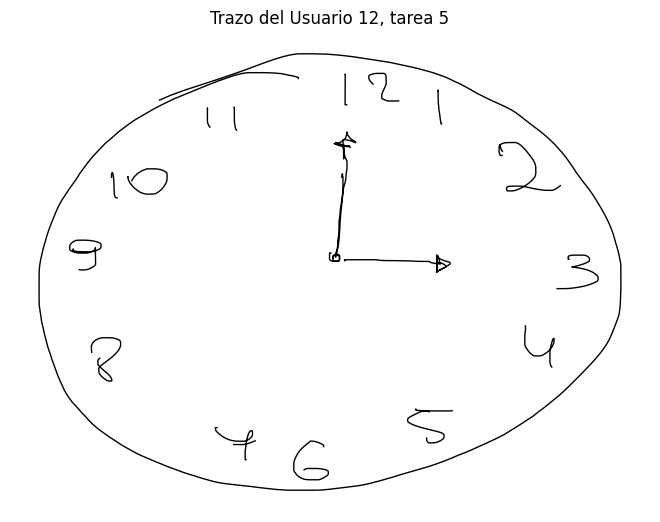

In [56]:
# Elegir un usuario y una tarea al azar (por ejemplo, el primero)
num_tarea = np.random.randint(0, 6) 
num_usuario = np.random.randint(0, len(list_data_x[num_tarea]) - 1) 

# Datos de coordenadas del dibujo
datos_x = list_data_x[num_tarea][num_usuario].to_numpy()
datos_y = list_data_y[num_tarea][num_usuario].to_numpy()

# Datos de presion del lapiz usado
datos_p = list_data_p[num_tarea][num_usuario].to_numpy()

# Reasignamos los valores de X y Y a nan ya que solo nos interesa cuando presiona el lapiz en el papel
datos_x[datos_p == 0] = np.nan
datos_y[datos_p == 0] = np.nan

# Invertimos los datos de X para mejor visualizacion
datos_x_inv = -datos_x[:]

plt.axis('off') # Apagamos los axis de la imagen
plt.plot(datos_x_inv, datos_y, linewidth= 1, color='k') # Imprimimos la imagen
plt.subplots_adjust(left=0, right=1, bottom= 0, top=1) # Centramos la imagen
plt.title(f"Trazo del Usuario {num_usuario}, tarea {num_tarea}")
plt.show()

### Función para generar el DataSet Completo

In [160]:
# Convertir a una funcion
# def get_image(task_id, user_id,  )
# Aqui vamos a crear una imagen usando SNS
for num_tarea in range(7):
  data_lenght = len(list_data_x[num_tarea])
  for num_usuario in range(data_lenght):
    # num_tarea = 5
    # num_usuario = 7

    # Datos de coordenadas del dibujo
    datos_x = list_data_x[num_tarea][num_usuario].to_numpy()
    datos_y = list_data_y[num_tarea][num_usuario].to_numpy()

    # Datos de presion del lapiz usado
    datos_p = list_data_p[num_tarea][num_usuario].to_numpy()

    # Reasignamos los valores de X y Y a nan ya que solo nos interesa cuando presiona el lapiz en el papel
    datos_x[datos_p == 0] = np.nan
    datos_y[datos_p == 0] = np.nan

    # Invertimos los datos de X para mejor visualizacion
    datos_x_inv = -datos_x[:]

    plt.axis('off') # Apagamos los axis de la imagen
    plt.plot(datos_x_inv, datos_y, linewidth= 1, color='k') # Imprimimos la imagen
    plt.subplots_adjust(left=0, right=1, bottom= 0, top=1) # Centramos la imagen


    # Salvamos la imagen
    figure = plt.gcf() # Sacamos la imagen actual
    figure.set_size_inches(2.24, 2.24)

    # when saving, specify the DPI
    # Generamos el nombre para nuestro dataset.
    file_name = f"task{num_tarea}_user_{num_usuario}.png"
    plt.savefig("DataSet/" + file_name, dpi = 100)
    plt.close()


# Modelo 1. Implementación con Keras

##  Parte 1. Implementar un Master Share Generador Basico

In [11]:
# Importar Librerias
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input

# Librerias Locales del Repositorio.
from watermark.dataset import DataHandler
from watermark.features import Utilities
from watermark.plots import PlotHandler

plot = PlotHandler()

**Implementación Basada en Articulo**
- Fierro-Radilla, A., Nakano-Miyatake, M., Cedillo-Hernandez, M., Cleofas-Sanchez, L., & Perez-Meana, H. (2019). A Robust Image Zero-watermarking using Convolutional Neural Networks. 2019 7th International Workshop on Biometrics and Forensics (IWBF). doi:10.1109/iwbf.2019.8739245 

- Vamos a Generar un objeto denomidado "Master Share" que sera una "llave" con base a una imagen donde se implementa un Zero-WaterMark y genera una "Master Share"


### 1.1 Adaptar una ResNet101 Pre-Entrenada
- Tomamos una ResNet101 lo que significa que tomamos un modelos de una Red Residual de 101 capas de convolución mediante la cual vamos a utilizar para tareas de obtención de carácteristicas de la imagen de entrada. 

- Requerimos adaptar esta ResNet101 ya que la salida original es de 100 features pero para esta implementación requerimos 152 features.

In [12]:
# Cargamos el modelo pre-entrenado de ResNet101
ResNet101_model = ResNet101(weights='imagenet', include_top=False, pooling='avg') 
ResNet101_model.trainable = False # Guardamos los parametros
# Tomamos la utilma capa de la ResNet y le agregamos una capa Densa con la forma 
# nuestro watermark
x = ResNet101_model.output 
x = Dense(152, activation=None)(x)

main_model = Model(inputs=ResNet101_model.input, outputs=x)

### 1.2 Obtener la Features (Caracteristicas) de una Imagen.
- Obtenemos las "Features" caraterisiticas de la imagen y aplicamos un filtro para binarizar la imagen, esto lo hacemos para una implementación correcta para realizar una operación XOR.

Imagen a Usar DataSet/task5_user_31.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


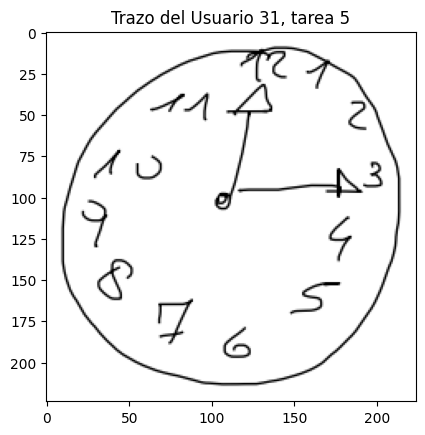

In [24]:
# Preparamos una Imagen de Prueba.
user_num = np.random.randint(129)
task_num = np.random.randint(7)
image_path = f'DataSet/task{task_num}_user_{user_num}.png'
print('Imagen a Usar', image_path)

# Cargamos la imagen en el modelo para generar sus features.
img = image.load_img(image_path, target_size=(224, 224)) # ResNet input size

plt.imshow(img) # Mostrar imagen
plt.title(f"Trazo del Usuario {user_num}, tarea {task_num}")

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)  
x = preprocess_input(x)

# Realizamos una prediccion con el modelo y obtenemos las Features
features = main_model.predict(x)[0]

Largo de Features:  152
Valores Features: [0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1.]


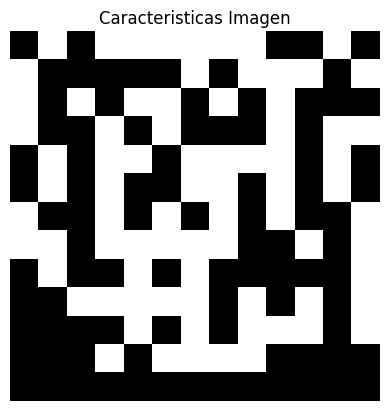

In [25]:
# Filtrado del Vector Features a Binario
features[features > 0] = 1
features[features <= 0] = 0
print('Largo de Features: ', len(features))
print('Valores Features:', features[::10])

# Mostrar la Features en formato de Matrix
plot.plot_master(features, 'Caracteristicas Imagen')

### 1.3 Generar una Fecha Aleatoria
- Generamos una fecha aleatoria en formato texto el cual posteriormente pasamos a un formato binarizado utilizando el ASCII.

Fecha a Utilizar:  2007/11/16 17:24:21
Largo de Fecha:  152
Valores Fecha: [0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0]


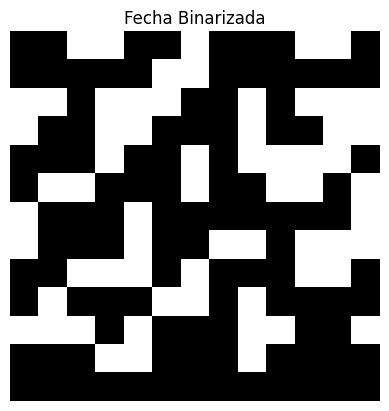

In [26]:
# Generador de WaterMarks usando Fechas
utils = Utilities()
# Generamos 10 Fechas Aleatorias
date = utils.dates_generator(1)[0]
print('Fecha a Utilizar: ', date)
date_bin = utils.string2bit(date)
print('Largo de Fecha: ', len(date_bin))
print('Valores Fecha:', date_bin[::10])

# Mostrar la Fecha en formato de Matrix
plot.plot_master(date_bin, 'Fecha Binarizada')

### 1.4 Generar "Llave" Master Share
- Realizamos la operación XOR entre las "Features" de la imagen y la Fecha Binarizada para generar de esta manera una **Llave** (Master Share) única para esta imagen.

Largo de Master Share:  152
Valores Master Share: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


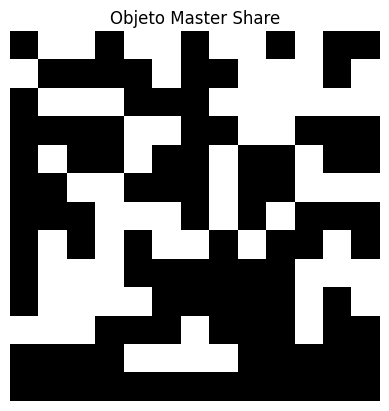

In [27]:
# Generamos el Master Share utilizando una operacion XOR
master_share = utils.array_xor(date_bin, features)
print('Largo de Master Share: ', len(master_share))
print('Valores Master Share:', master_share[::10])

plot.plot_master(master_share, 'Objeto Master Share')

## Parte 2. Implementar Image Verificator

### 2.1 Generar Features de una imagen de prueba

Imagen a Usar DataSet/task5_user_31.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


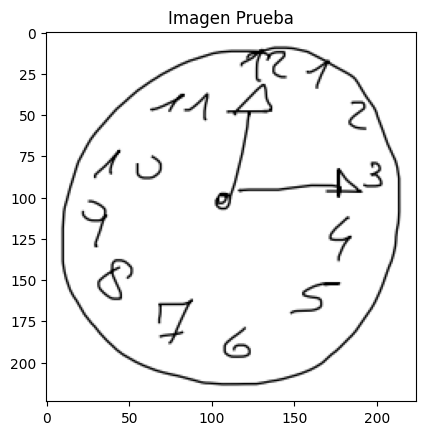

In [29]:
# Utilizamos el mismo modelo de toma de Features.

# # Preparamos una Imagen de Prueba.
# img_num = np.random.randint(129)
# image_path2 = f'DataSet/task0_user_{img_num}.png'
# print('Imagen a Usar', image_path2)

# Vamos a usar la misma imagen.
print('Imagen a Usar', image_path)

# Cargamos la imagen en el modelo para generar sus features.
img = image.load_img(image_path, target_size=(224, 224)) # ResNet input size
plt.imshow(img) # Mostrar imagen
plt.title("Imagen Prueba")

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)  # Create a batch (batch size 1)
x = preprocess_input(x)

# Realizamos una prediccion con el modelo y obtenemos las Features
features = main_model.predict(x)[0]

In [30]:
# Filtrado del Vector Features a Binario
features[features > 0] = 1
features[features <= 0] = 0
print('Largo de Features: ', len(features))
print('Valores Features:', features[::10])

Largo de Features:  152
Valores Features: [0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1.]


### 1.2 Regenerar Fecha (WaterMark) utilizando la MasterShare

In [32]:
# Regeneramos la WaterMark aplicando un XOR entre las 
# features de la imagen y la mastershare
watermark = utils.array_xor(master_share, features)
print('Largo de Master Share: ', len(watermark))
print('Valores Master Share:', watermark[::10])

Largo de Master Share:  152
Valores Master Share: [0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0]


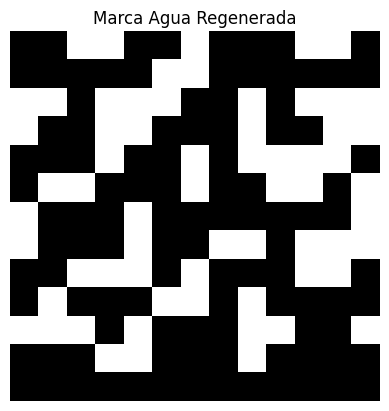

In [34]:
# Mostrar la Master Share en formato de Matrix
plot = PlotHandler()
plot.plot_master(watermark, "Marca Agua Regenerada")

In [35]:
print(utils.bit2string(watermark))

2007/11/16 17:24:21


# Modelo 2. Implementación con PyTorch

In [60]:
# Cargar el modelo ResNet101 preentrenado
resnet101 = models.resnet101(pretrained=True)

# Remover la capa final de clasificación (la capa fc)
resnet101 = torch.nn.Sequential(*list(resnet101.children())[:-1])

resnet101.eval()  # Poner el modelo en modo evaluación

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [61]:
# Lista para almacenar las imágenes preprocesadas
imagenes_preprocesadas = []

# Recorrer todos los usuarios y tareas, estandarizando y preprocesando las imágenes
for num_tarea in range(7):
  data_lenght = len(list_data_x[num_tarea])
  for num_usuario in range(data_lenght):
    # Obtener el trazo de un usuario y tarea específicos
    datos_x = np.array(list_data_x[num_tarea][num_usuario])
    datos_y = np.array(list_data_y[num_tarea][num_usuario])
    
    # Convertir el trazo a imagen
    img = dh.trazo_a_imagen_v2(datos_x, datos_y)

    # Preprocesar la imagen para ResNet101
    img_tensor = dh.preprocesar_imagen_tensor(img)
    
    # Añadir la imagen preprocesada a la lista
    imagenes_preprocesadas.append(img_tensor)

# Ver el tamaño de las imágenes preprocesadas
print(f"Cantidad de imágenes preprocesadas: {len(imagenes_preprocesadas)}")

Cantidad de imágenes preprocesadas: 902


In [62]:
imagenes_preprocesadas[0].shape

torch.Size([1, 3, 224, 224])

## Extracción de características de la imagen (Feature Vector Extraction)

In [63]:
# Lista para almacenar los vectores de características
feature_vectors = []

# Desactivar el cálculo de gradientes para la inferencia
with torch.no_grad():
    # Iterar sobre todas las imágenes preprocesadas
    for img_tensor in imagenes_preprocesadas:        
        # Pasar la imagen a través del modelo para obtener las características
        feature_map = resnet101(img_tensor)  # Salida de las capas convolucionales y pooling
        
        # Aplanar el tensor de características para obtener el vector de características
        feature_vector = feature_map.view(feature_map.size(0), -1)  # Aplanar a un vector de 2048 dimensiones
        
        # Añadir el vector de características a la lista
        feature_vectors.append(feature_vector)

print(f"Deep feature de la imagen 1: {feature_vectors[0]}")

Deep feature de la imagen 1: tensor([[0.6986, 0.3350, 0.0146,  ..., 2.2949, 0.0278, 0.0905]])


## Uso de DWT, DCT y Hash perceptual

In [64]:
# Lista para almacenar los vectores de características con DWT, DCT y hash perceptual
feature_vectors_dwt_dct_hash = []

# Desactivar el cálculo de gradientes para la inferencia
with torch.no_grad():
    # Iterar sobre cada vector de características (tienes 902 vectores)
    for idx, feature_vector in enumerate(feature_vectors):        
        # Aplicar DWT sobre el vector de características (usando una transformación 1D)
        coeffs = pywt.dwt(feature_vector.squeeze().cpu().numpy(), 'db1')  # 'db1' es un tipo de wavelet común (Daubechies)
        cA, cD = coeffs  # Coeficientes aproximados (cA) y detalles (cD)
        
        # Aplicar DCT sobre los coeficientes aproximados (cA)
        cA_dct = dct(cA, norm='ortho')
        
        # Extraer los primeros 64 coeficientes válidos de la DCT
        low_freq_coeffs = cA_dct[:64].reshape(8,8)  # Tomamos los primeros 32 coeficientes
        
        # Normalizar los coeficientes para que estén en [0, 255] y convertir a uint8
        low_freq_matrix_norm = np.uint8(np.interp(low_freq_coeffs, 
                                                  (low_freq_coeffs.min(), low_freq_coeffs.max()), 
                                                  (0, 255)))

        # Convertir la matriz en imagen PIL
        img = Image.fromarray(low_freq_matrix_norm, mode="L")  

        # Aplicar el perceptual hash con un tamaño mayor (32x32 bits)
        ph = phash(img, hash_size=32)  

        # Convertir el hash en una matriz 32x32
        hash_matrix = np.array(ph.hash, dtype=int)

        # Guardar el hash en formato de matriz
        feature_vectors_dwt_dct_hash.append(hash_matrix)

Comprobación del largo de las caracteristicas obtenidas.

In [65]:
len(feature_vectors_dwt_dct_hash) # Deberías tener 902 hashes perceptuales (confirmacion de hashes creados)

902

Una vez que los coeficientes válidos de la DCT han sido extraídos, se aplico un algoritmo de perceptual hashing para obtener un vector de características único y robusto para cada imagen. 
Este hash perceptual representará de manera compacta las características relevantes de la imagen.

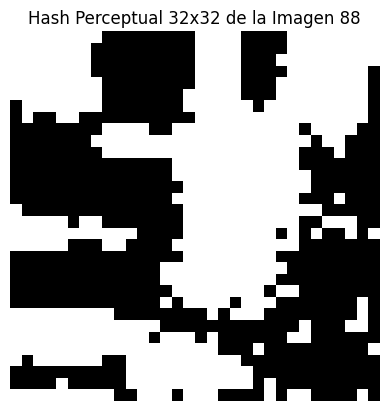

In [66]:
# Seleccionar un hash de ejemplo y visualizarlo
ejemplo_idx =   random.randint(0,902)# Puedes cambiar el índice para ver otro hash
plt.imshow(feature_vectors_dwt_dct_hash[ejemplo_idx], cmap="gray")
plt.title(f"Hash Perceptual 32x32 de la Imagen {ejemplo_idx+1}")
plt.axis("off")
plt.show()

## Watermark Image

In [67]:
util = Utilities() # Objeto de utilidades de features.

### Fecha a imagen cambiando a binario y despues haciendolo imagen la fecha binarizada

Fecha a Utilizar:  1995/07/20 15:54:07


(np.float64(-0.5), np.float64(7.5), np.float64(7.5), np.float64(-0.5))

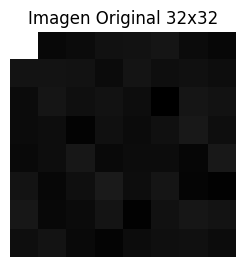

In [ ]:
# Generamos Fechas Aleatorias ejemplo para hacer la funcion
date = util.dates_generator(1)[0]
print('Fecha a Utilizar: ', date)


binario = ''.join(format(ord(c), '08b') for c in date)  # 8 bits por carácter

# 2. Asegurar que tenemos 1024 bits (32x32)
faltantes = 1024 - len(binario)
if faltantes > 0:
    binario += ''.join(str(b) for b in np.random.randint(0, 2, faltantes))  # Rellenar con 0 y 1 aleatorio

# Convertir a matriz 32x32
bit_array = np.array([int(b) for b in binario[:1024]]).reshape(32, 32) 
bit_array= np.where(bit_array== 1,255, 0)  # Convertir a escala de grises

# 3. Crear imagen a partir de la matriz de bits
fecha_image = Image.fromarray(np.uint8(bit_array), mode="L")

# Mostrar la imagen original
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Imagen Original 32x32")
plt.axis("off")

### Uso de logistic chaotic map para cirfar la imagen asi como el guardado de los indices de permutacion para poder decrifrar posteriormente,

Forma de la imagen cifrada: (32, 32)


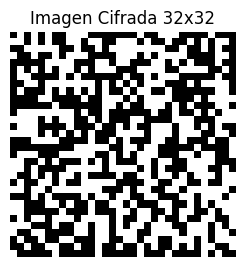

In [69]:
# Aplicar el cifrado caótico
encrypted_img, _ = util.logistic_map_encrypt(bit_array)

# Verificar forma de la imagen
print("Forma de la imagen cifrada:", encrypted_img.shape)

# Mostrar la imagen cifrada
plt.subplot(1, 2, 2)
plt.imshow(encrypted_img, cmap="gray")
plt.title("Imagen Cifrada 32x32")
plt.axis("off")
plt.show()

## Embedding del Zero Watermark

In [70]:
# Definir la carpeta donde se guardarán las claves secretas
output_folder = "logical_secret_keys"
os.makedirs(output_folder, exist_ok=True)

## Imagenes de la fecha encriptadas

In [71]:
encript = Encription_images() # Objeto de encriptacion de imagenes.
encrypted_arr_images, stored_chaos_indices=encript.generate_encrypted_date_images(len(feature_vectors_dwt_dct_hash))

### Operacion XOR para obtener logical secret keys 

In [72]:
secret_keys = {}  # Diccionario para almacenar las claves secretas
for idx, (phash_matrix, encrypted_tuple) in enumerate(zip(feature_vectors_dwt_dct_hash, encrypted_arr_images)):
    # Extraer solo la imagen encriptada (segundo elemento de la tupla)
    encrypted_img = encrypted_tuple[2]

    # Convertir la imagen de PIL a un array NumPy en escala de grises
    encrypted_img = np.array(encrypted_img, dtype=np.uint8)
    phash_matrix = np.array(phash_matrix, dtype=np.uint8)

    # Asegurar que las dimensiones coinciden
    if encrypted_img.shape != phash_matrix.shape:
        raise ValueError(f"Dimensiones incompatibles: {phash_matrix.shape} vs {encrypted_img.shape}")

    # Aplicar XOR para generar la Logical Secret Key
    logical_secret_key = np.bitwise_xor(encrypted_img, phash_matrix)
    
    # Convertir la clave en una lista para JSON
    secret_keys[f"secret_key_{idx+1}"] = logical_secret_key.tolist()

# Guardar las claves en un archivo JSON
key_json_path = os.path.join(output_folder, "secret_keys.json")
with open(key_json_path, "w") as json_file:
    json.dump(secret_keys, json_file, indent=4)

print(f"Claves secretas guardadas en {key_json_path}")


Claves secretas guardadas en logical_secret_keys\secret_keys.json


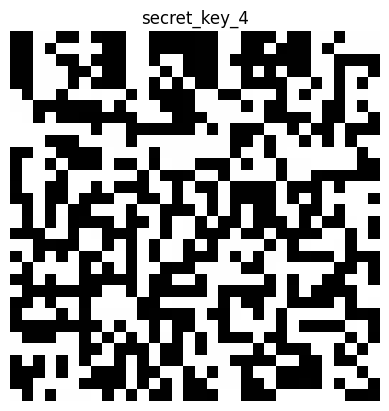

In [73]:
# Ruta del archivo JSON
key_json_path = "logical_secret_keys/secret_keys.json"

# Cargar el JSON
with open(key_json_path, "r") as json_file:
    secret_keys = json.load(json_file)

# Imprimir una clave específica (por ejemplo, "secret_key_1")
key_name = "secret_key_4"
if key_name in secret_keys:
    # Convertir la lista almacenada en el JSON a un array NumPy
    logical_secret_key = np.array(secret_keys[key_name], dtype=np.uint8)
    
    # Mostrar la imagen con matplotlib
    plt.imshow(logical_secret_key, cmap="gray")
    plt.axis("off")  # Ocultar ejes
    plt.title(key_name)
    plt.show()
else:
    print(f"La clave {key_name} no existe en el JSON.")

## Process extraction zero-watermark 

In [74]:
# Cargar las claves secretas
key_json_path = os.path.join(output_folder, "secret_keys.json")
with open(key_json_path, "r") as json_file:
    secret_keys = json.load(json_file)

# Lista para almacenar las imágenes encriptadas reconstruidas
recovered_encrypted_images = []

for idx, (phash_matrix) in enumerate(feature_vectors_dwt_dct_hash):
    # Obtener la clave secreta correspondiente
    logical_secret_key = np.array(secret_keys[f"secret_key_{idx+1}"], dtype=np.uint8)
    phash_matrix = np.array(phash_matrix, dtype=np.uint8)

    # Asegurar que las dimensiones coinciden
    if logical_secret_key.shape != phash_matrix.shape:
        raise ValueError(f"Dimensiones incompatibles: {logical_secret_key.shape} vs {phash_matrix.shape}")

    # Aplicar XOR para recuperar la imagen encriptada
    encrypted_img = np.bitwise_xor(logical_secret_key, phash_matrix)

    # Convertir de array a imagen PIL y agregar a la lista
    recovered_encrypted_images.append((idx, Image.fromarray(encrypted_img)))

print("Imágenes encriptadas recuperadas exitosamente.")

Imágenes encriptadas recuperadas exitosamente.


In [75]:
recovered_encrypted_images[0]

(0, <PIL.Image.Image image mode=L size=32x32>)

In [76]:
# Ajuste para integrar recovered_encrypted_images con logistic_map_decrypt
recovered_decrypted_images = []

for idx, encrypted_pil_img in recovered_encrypted_images:
    # Convertir la imagen recuperada en un array NumPy
    encrypted_matrix = np.array(encrypted_pil_img, dtype=np.uint8)
    

    # Cargar el chaos_idx correspondiente (esto depende de cómo lo almacenaste)
    chaos_idx = np.array(stored_chaos_indices[idx])  # Se asume que tienes un diccionario con los índices de permutación

    # Aplicar descifrado con Logistic Map
    decrypted_matrix = encript.logistic_map_decrypt(encrypted_matrix, chaos_idx)

    # Convertir de nuevo a imagen PIL
    decrypted_pil_img = Image.fromarray(decrypted_matrix)

    # Almacenar la imagen descifrada
    recovered_decrypted_images.append((idx, decrypted_pil_img))

print("Imágenes descifradas exitosamente.")

Imágenes descifradas exitosamente.


### Comparacion fecha desencriptada vs fecha usada para la marca de agua 

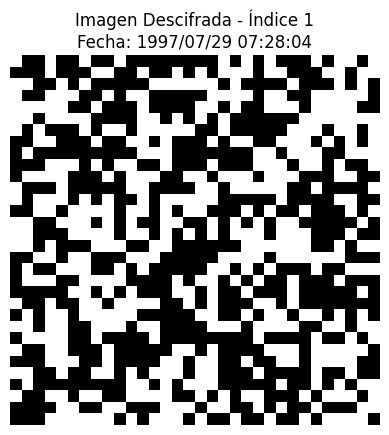

Índice fecha cifrada: 1, Fecha: 1997/07/29 07:28:04

Las fechas coinciden.


In [77]:
# Seleccionar la primera imagen descifrada

if recovered_decrypted_images:
    idx, decrypted_pil_img = recovered_decrypted_images[1]  # Obtener la primera imagen descifrada
    
    # Buscar la fecha asociada al índice en encrypted_arr_images
    original_date = None
    for enc_idx, date, _, _ in encrypted_arr_images:
        if enc_idx == idx:
            original_date = date
            break

    # Mostrar la imagen descifrada
    plt.imshow(decrypted_pil_img, cmap='gray')
    plt.title(f'Imagen Descifrada - Índice {idx}\nFecha: {original_date}')
    plt.axis('off')
    plt.show()
else:
    print("No hay imágenes descifradas disponibles.")

 # Cargar el archivo JSON
with open("generated_data.json", "r") as f:
    data = json.load(f)

# Obtener la primera fecha
first_idx = list(data["dates"].keys())[1]  # Obtener la primera clave (índice)
first_date = data["dates"][first_idx]  # Obtener la fecha correspondiente

# Imprimir la primera fecha
print(f"Índice fecha cifrada: {first_idx}, Fecha: {first_date}\n")

if first_date == original_date: # Comparar la fecha original con la descifrada
    print("Las fechas coinciden.")
else:
    print("Las fechas no coinciden.")   # Imprimir mensaje si las fechas no coinciden


# Conclusiones de Modelos.

- En el Avance Anterior optamos por realizar 2 implementaciones utilizando el mismo modelo ResNet101 pero con modificaciones puntuales, y con la implementación utilizando 2 frameworks diferentes siendo estos (Keras/Tensorflow y Pytorch)

Pasando con la implementación primeramente el equipo se enfocó en realizar una implementación básica de Zero-Watermark en la cual no se contaba con una gran robustes en cuando a la creación de las llaves de cada imagen pero buscaba el objetivo de entender de mejor manera el proceso que implementariamos en la siguiente fase. 

Para este primer intento se utilizó una red ResNet101 pre-entrenada guardada en el framework de Tensorflow, dicha red fue a su vez modificada para cambiar la capa de salida de 100 valores o categorias, a 152 valores que eran las caracteristicas de la imagen utilizada. Esto se hizo de esta manera para poder conectar con los 152 bits generados de una fecha pasada de string a valores de bit. Posterior a esto se implemento una operación XOR entre las caracteristicas de la imagen y la "WaterMark" que es la fecha en formato binario y con esto obtuvimos una llave que llamamos Master Share. De igual manera el proceso de verificación de las imagenes fue muy directo en donde de igual manera utilizamos la red ResNet101 modificada, para obtener caracteristica de una imagen de prueba y al aplicar la misma operación XOR con la MasterShare, se espera obtener un vector binario que al decodificar a un String se espera ver la fecha del WaterMark.

Para el segundo intento una vez lograda la implementación básica pasamos por una implementación con mayor robustes en la cual de la misma manera implementamos la ResNet101 usando el framework de PyTorch, pero en este intento tuvimos que modificar la capa de salida para pasar de las 100 categorias de la red original a una capa de 2048 valores las cuales serán las caracteristicas de la imagen obtenidas por la red. Posterior a esto realizamos un proceso doble de transformación al vector de features utilizando un DWT (Discrete Wave Transform) y un DCT (Discrete Cosine Transform) que de manera resumida son transformada al dominio de frecuencia, posterior a esto realizamos una operación Hash para la protección de todos estos datos. 

Finalmente realizamos un proceso similar de binarización de la fecha "Watermark" unicamente agregando un proceso de encriptado a los bits de la fecha, posterior a esto seguimos el mismo proceso para generar una llave la cual guardamos en un archivo Json para uso futuro. Ya como ultimos pasos realizamos el mismo proceso inverso descrito en la primera parte para reobtener la Watermark seleccionada.

En conclusión se usaron dos modelos pre-entrenados ResNet101 los cuales fueron modificados en sus capas finales para atender una necesidad de dimensionalidad para el problema, nosotros consideramos que el modelo ResNet101 para el caso 2, será el indicado para nuestro proyecto, ya que este modelo se especializa en la extracción de características de una imagen. De igual manera como nota adicional el equipo a estado considerando en bajar el nivel de la red ya que existen varios modelos de ResNet que disminuyen la cantidad de capas de convolución, esta decisión es debido a la consideración del dataset al utilizar imagenes de un solo canal y que no son a nuestro parecer muy complejas.